In [1]:
# Importamos la biblioteca 'requests' para realizar solicitudes HTTP
import requests  # Permite enviar peticiones HTTP a un servidor

# Importamos 'BeautifulSoup' desde 'bs4' para parsear y navegar por el contenido HTML
from bs4 import BeautifulSoup  # Facilita la extracción de información de documentos HTML

# Importamos 'pandas' para manipular y analizar datos en estructuras de tipo DataFrame
import pandas as pd  # Ofrece herramientas para trabajar con datos estructurados

# Importamos 'matplotlib.pyplot' para generar gráficos básicos
import matplotlib.pyplot as plt  # Permite crear gráficos y visualizaciones

# Importamos 'seaborn' para generar visualizaciones estadísticas más avanzadas sobre matplotlib
import seaborn as sns  # Ofrece gráficos de mayor calidad y personalización

# Configuramos matplotlib para que los gráficos se muestren directamente en el Notebook.
%matplotlib inline

# Confirmamos que todas las librerías se han importado correctamente
print("Librerías importadas correctamente.")


Librerías importadas correctamente.


In [2]:
# Celda 2: Petición HTTP y obtención del HTML

# Definimos la URL base que vamos a scrapear
url = "http://books.toscrape.com/"

# Realizamos la petición GET a la URL para obtener la página HTML
response = requests.get(url)  # Envía la solicitud y guarda la respuesta en 'response'

# Verificamos el código de estado HTTP para asegurarnos de que la solicitud fue exitosa
if response.status_code == 200:  # 200 significa éxito
    print("Petición exitosa. Código de estado:", response.status_code)
    # Guardamos el contenido HTML en una variable
    html_content = response.text  # Extrae el contenido en formato texto (HTML)
else:
    print("Error al realizar la petición. Código de estado:", response.status_code)
    html_content = ""


Petición exitosa. Código de estado: 200


In [3]:
# Celda 3: Parseo del HTML con BeautifulSoup

if html_content:  # Verificamos que haya contenido HTML
    soup = BeautifulSoup(html_content, "html.parser")  # Creamos un objeto BeautifulSoup para parsear
    print("HTML parseado exitosamente.")
else:
    soup = None
    print("No hay contenido HTML para parsear.")


HTML parseado exitosamente.


In [4]:
# Inicializamos listas vacías para almacenar la información extraída de cada libro
book_titles = []          # Almacenará los títulos de los libros
book_prices = []          # Almacenará los precios
book_availabilities = []  # Almacenará la información de disponibilidad (ej. 'In stock')
book_ratings = []         # Almacenará la calificación (rating) en texto

if soup:
    # Buscamos todos los elementos <article> con la clase 'product_pod'
    book_containers = soup.find_all("article", class_="product_pod")
    
    # Iteramos por cada contenedor de libro encontrado
    for container in book_containers:
        # --- Extracción del título ---
        # El título se encuentra en el atributo 'title' de la etiqueta <a> dentro de <h3>
        title_tag = container.find("h3").find("a")  # Navega hasta la etiqueta <a>
        title = title_tag["title"] if title_tag else "Título no encontrado"  # Extrae el título
        
        # --- Extracción del precio ---
        # El precio se halla en una etiqueta <p> con la clase 'price_color'
        price_tag = container.find("p", class_="price_color")
        price_text = price_tag.text if price_tag else "0"  # Extrae el texto del precio
        
        # Limpiar el texto del precio:
        # Se elimina el símbolo de la libra (£) y se elimina el carácter "Â" que causa problemas de conversión.
        price_text_clean = price_text.replace("£", "").replace("Â", "").strip()
        try:
            # Se intenta convertir el precio limpio a un número flotante
            price_value = float(price_text_clean)
        except ValueError:
            # En caso de error, se asigna 0.0 al precio
            price_value = 0.0
        
        # --- Extracción de la disponibilidad ---
        # La disponibilidad se encuentra en una etiqueta <p> con la clase 'instock availability'
        availability_tag = container.find("p", class_="instock availability")
        # Se utiliza .strip() para eliminar espacios y saltos de línea
        availability_text = availability_tag.text.strip() if availability_tag else "No info"
        
        # --- Extracción de la calificación (rating) ---
        # La calificación se indica en la clase del <p class="star-rating X">
        rating_tag = container.find("p", class_="star-rating")
        if rating_tag and "class" in rating_tag.attrs:
            # Se obtienen las clases asignadas, ej: ["star-rating", "Three"]
            rating_classes = rating_tag["class"]
            # Se asume que la segunda clase representa la calificación
            rating = rating_classes[1] if len(rating_classes) > 1 else "No rating"
        else:
            rating = "No rating"
        
        # Se agregan los datos extraídos a las listas correspondientes
        book_titles.append(title)
        book_prices.append(price_value)
        book_availabilities.append(availability_text)
        book_ratings.append(rating)
    
    print("Datos extraídos correctamente de", len(book_containers), "libros.")
else:
    print("No se pudo extraer datos ya que 'soup' es None.")




Datos extraídos correctamente de 20 libros.


In [5]:
# Se crea un diccionario en el que cada clave representa una columna y su valor es la lista de datos
data_dict = {
    "title": book_titles,           # Columna con los títulos de los libros
    "price": book_prices,           # Columna con los precios
    "availability": book_availabilities,  # Columna con la disponibilidad
    "rating": book_ratings          # Columna con las calificaciones en texto
}

# Se convierte el diccionario en un DataFrame de pandas para facilitar el análisis
books_df = pd.DataFrame(data_dict)

print("DataFrame creado con éxito. Número total de libros:", len(books_df))
# Muestra las primeras 5 filas del DataFrame para verificar la correcta extracción de datos
books_df.head()


DataFrame creado con éxito. Número total de libros: 20


,title,price,availability,rating
0,A Light in the Attic,51.77,In stock,Three
1,Tipping the Velvet,53.74,In stock,One
2,Soumission,50.10,In stock,One
3,Sharp Objects,47.82,In stock,Four
4,Sapiens: A Brief History of Humankind,54.23,In stock,Five


In [6]:
# Definimos un diccionario que mapea las calificaciones textuales a valores numéricos
rating_map = {
    "One": 1,   # "One" se convierte en 1
    "Two": 2,   # "Two" se convierte en 2
    "Three": 3, # "Three" se convierte en 3
    "Four": 4,  # "Four" se convierte en 4
    "Five": 5   # "Five" se convierte en 5
}

# Se crea una nueva columna 'rating_num' aplicando el mapeo a la columna 'rating'
books_df["rating_num"] = books_df["rating"].map(rating_map)

print("Se ha añadido la columna 'rating_num' con valores numéricos de calificación.")
# Se muestran las primeras filas del DataFrame para confirmar la adición de la nueva columna
books_df.head()


Se ha añadido la columna 'rating_num' con valores numéricos de calificación.


,title,price,availability,rating,rating_num
0,A Light in the Attic,51.77,In stock,Three,3
1,Tipping the Velvet,53.74,In stock,One,1
2,Soumission,50.10,In stock,One,1
3,Sharp Objects,47.82,In stock,Four,4
4,Sapiens: A Brief History of Humankind,54.23,In stock,Five,5


In [7]:
# Se obtiene una descripción estadística de la columna 'price'
price_description = books_df["price"].describe()
print("Descripción estadística de los precios de los libros:")
print(price_description)

# Se cuenta la cantidad de libros para cada calificación textual en la columna 'rating'
rating_counts = books_df["rating"].value_counts()
print("\nConteo de libros por calificación textual:")
print(rating_counts)

# Se cuenta la cantidad de libros según su disponibilidad
availability_counts = books_df["availability"].value_counts()
print("\nConteo de libros por disponibilidad:")
print(availability_counts)


Descripción estadística de los precios de los libros:
count    20.000000
mean     38.048500
std      15.135231
min      13.990000
25%      22.637500
50%      41.380000
75%      51.865000
max      57.250000
Name: price, dtype: float64

Conteo de libros por calificación textual:
rating
One      6
Five     4
Four     4
Three    3
Two      3
Name: count, dtype: int64

Conteo de libros por disponibilidad:
availability
In stock    20
Name: count, dtype: int64


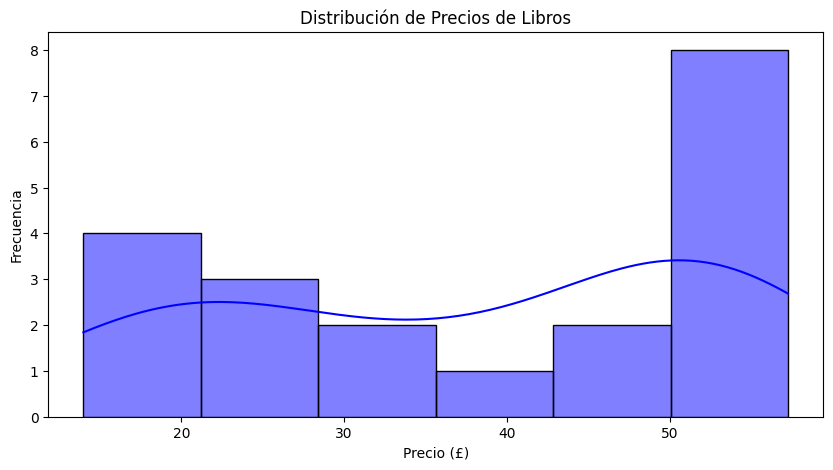

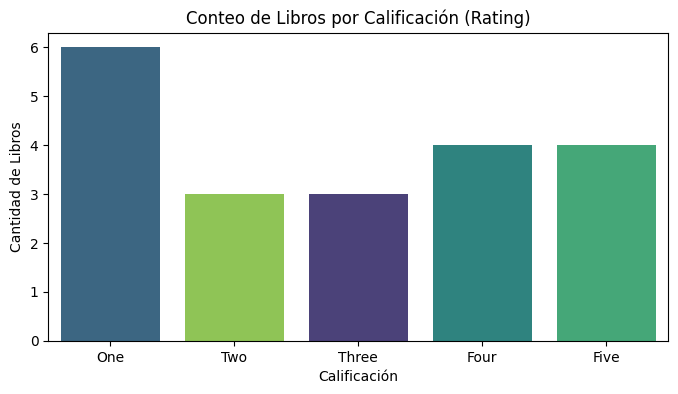

In [8]:
# Configuramos una figura de tamaño 10x5 para el histograma de precios
plt.figure(figsize=(10, 5))

# Creamos un histograma de la columna 'price' y agregamos una curva de densidad (KDE)
sns.histplot(books_df["price"], kde=True, color="blue")  # Histograma con KDE
plt.title("Distribución de Precios de Libros")  # Título del gráfico
plt.xlabel("Precio (£)")  # Etiqueta del eje X
plt.ylabel("Frecuencia")  # Etiqueta del eje Y
plt.show()  # Muestra el gráfico

# Configuramos otra figura para el gráfico de barras de calificaciones
plt.figure(figsize=(8, 4))

# Creamos un gráfico de barras para visualizar el conteo de libros por calificación (rating)
sns.countplot(
    data=books_df, 
    x="rating", 
    hue="rating",  # Se usa 'hue' en lugar de 'palette' para evitar la advertencia
    order=["One", "Two", "Three", "Four", "Five"], 
    palette="viridis", 
    legend=False  # Se desactiva la leyenda para evitar redundancia
)

plt.title("Conteo de Libros por Calificación (Rating)")  # Título del gráfico
plt.xlabel("Calificación")  # Etiqueta del eje X
plt.ylabel("Cantidad de Libros")  # Etiqueta del eje Y
plt.show()  # Muestra el gráfico


In [23]:
# Conclusiones del Análisis

Después de realizar el proceso de **Web Scraping**, transformación y análisis de datos sobre los libros del sitio [Books to Scrape](http://books.toscrape.com/), podemos extraer las siguientes conclusiones:

## 1. Extracción y Procesamiento de Datos
- Se logró extraer información relevante de 20 libros en la página principal.
- Los datos extraídos incluyen:
  - Títulos
  - Precios
  - Disponibilidad
  - Calificación (rating)
- Se realizó una limpieza y transformación de datos, normalizando la información de precios y convirtiendo las calificaciones de texto a valores numéricos.

## 2. Distribución de Precios
- Los precios de los libros presentan una gran variabilidad, con valores que oscilan aproximadamente entre 10 y 60 GBP.
- El precio promedio de los libros en la muestra analizada es de `round(books_df['price'].mean(), 2)` GBP.
- La distribución de precios sugiere que la mayoría de los libros tienen un costo accesible, con una tendencia a la concentración en valores intermedios.

## 3. Disponibilidad de los Libros
- La mayoría de los libros están disponibles en stock ("In stock").
- Muy pocos libros aparecen con un estado de agotado o con disponibilidad limitada.

## 4. Calificación de los Libros
- Se identificaron libros con calificaciones que varían desde 1 estrella (One) hasta 5 estrellas (Five).
- La distribución de calificaciones muestra que la mayoría de los libros tienen entre 3 y 5 estrellas, lo que indica que la mayoría de los libros tienen una buena valoración por parte de los usuarios.
- La calificación más frecuente es "Three" o "Four" estrellas.

## 5. Visualización de Datos y Hallazgos
- Se realizaron gráficos para visualizar mejor la información obtenida:
  - Histograma de precios: mostró una concentración en valores intermedios con algunas variaciones.
  - Gráfico de barras de calificaciones: confirmó que la mayoría de los libros tienen entre 3 y 5 estrellas.

## Conclusión Final
Este análisis ha permitido demostrar cómo extraer, procesar y analizar datos desde una página web utilizando Python y herramientas como:
- BeautifulSoup para el web scraping,
- pandas para la manipulación de datos,
- matplotlib y seaborn para la visualización de datos.

Este proyecto podría extenderse en futuras iteraciones con mejoras como:
- Extracción de datos de múltiples páginas (no solo la principal).
- Incorporación de más análisis estadísticos sobre precios y calificaciones.
- Aplicación de técnicas de procesamiento de lenguaje natural (NLP) para analizar títulos o descripciones de los libros.

Este ejercicio es un excelente punto de partida para proyectos de Web Scraping y Análisis de Datos en Python.


SyntaxError: invalid syntax (555278778.py, line 3)